# check and draw box

In [1]:
import os
import json
import os.path as osp
import numpy as np
from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm

In [2]:
json_path = '/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/voc_all.json'
img_dir = '/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/image'
box_img_dir = '/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/box_image'
with open(json_path) as f:
    all_data = json.load(f)

In [3]:
images_info = all_data['images']
print(images_info[:5])

[{'file_name': '000001.jpg', 'height': 1080, 'width': 1920, 'id': 1}, {'file_name': '000002.jpg', 'height': 1080, 'width': 1920, 'id': 2}, {'file_name': '000003.jpg', 'height': 1080, 'width': 1920, 'id': 3}, {'file_name': '000004.jpg', 'height': 1080, 'width': 1920, 'id': 4}, {'file_name': '000005.jpg', 'height': 1080, 'width': 1920, 'id': 5}]


In [4]:
annotations_info = []
for ann in all_data['annotations']:
    ann.pop('id')  # remove annotation id
    ann.pop('iscrowd')
    annotations_info.append(ann)
print(annotations_info[:5])

[{'segmentation': [712, 415, 839, 415, 839, 574, 712, 574], 'area': 20193, 'image_id': 1, 'bbox': [712, 415, 127, 159], 'category_id': 0, 'ignore': 0}, {'segmentation': [129, 940, 301, 940, 301, 1082, 129, 1082], 'area': 24424, 'image_id': 1, 'bbox': [129, 940, 172, 142], 'category_id': 1, 'ignore': 0}, {'segmentation': [344, 894, 468, 894, 468, 1003, 344, 1003], 'area': 13516, 'image_id': 1, 'bbox': [344, 894, 124, 109], 'category_id': 1, 'ignore': 0}, {'segmentation': [653, 799, 793, 799, 793, 925, 653, 925], 'area': 17640, 'image_id': 1, 'bbox': [653, 799, 140, 126], 'category_id': 1, 'ignore': 0}, {'segmentation': [342, 540, 469, 540, 469, 674, 342, 674], 'area': 17018, 'image_id': 1, 'bbox': [342, 540, 127, 134], 'category_id': 1, 'ignore': 0}]


In [5]:
category_dict = {x['name']: x['id'] for x in all_data['categories']}
label_tag = {id:name for name, id in category_dict.items()}
color_dict = {'echinus': 'red', 'starfish': 'green', 'holothurian': 'blue', 'scallop': 'purple'}
print(label_tag)

{0: 'holothurian', 1: 'echinus', 2: 'scallop', 3: 'starfish'}


In [6]:
# draw box with pillow
def draw_box_with_pil(image, bbox, label, color_dict):
    """

    :param image:
    :param bbox:
    :param label:
    :param color_dict:
    :return:
    """

    img_w = image.size[0]
    img_h = image.size[1]

    bbox = np.array(bbox, dtype=np.int32).reshape(-1, 4)
    # print('image shape ({},{})'.format(img_w, img_h))
    # set font
    font = ImageFont.truetype(font=fm.findfont(fm.FontProperties()),
                              size=np.floor(1.5e-2 * img_w ).astype(np.int32), encoding="unic")

    # draw box
    draw = ImageDraw.Draw(image)
    for box, tag in zip(bbox, label):
        # get label size
        label_size = draw.textsize(tag, font)
        # get label start point
        text_origin = np.array([box[0], box[1] - label_size[1]])
        # draw bbox rectangle and label rectangle
        draw.rectangle([box[0], box[1], box[2], box[3]], outline=color_dict[tag], width=2)
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=color_dict[tag])
        draw.text(text_origin, str(tag), fill=(255, 255, 255), font=font)

    return image

In [7]:
for img in tqdm(images_info):
    img_name = img['file_name']
    img_id = img['id']
    img_w, img_h = img['width'], img['height']
    # get image bbox
    bboxs = []
    labels = []
    for anns in annotations_info:
        if anns['image_id'] == img['id']:
            x1, y1, w, h = anns['bbox']
            
            ###############step 1:check area####################
            w, h = w -1, h - 1
            if anns['area'] < 0 or w < 0 or h < 0:
                print(anns['area'], w, h)
                continue
            # x1, y1, x2, y2 = x1, y1, x1 + w, y1 + h
            ###################restrict bbox to image area###################
            x1 = max(x1, 0)
            y1 = max(y1, 0)
            x2 = min(x1 + w, img_w)
            y2 = min(y1 + h, img_h)
            bboxs.append([x1, y1, x2, y2])
            labels.append(anns['category_id'])

    bboxs = np.array(bboxs, dtype=np.int32).reshape(-1, 4)
    # assert (bboxs[:, 2] >= 1).all(), "Warning, {}  bbox tag error in width aspect {}".format(img_name, bboxs)
    # assert (bboxs[:, 3] >= 1).all(), "Warning, {}  bbox tag error in height aspect {}".format(img_name, bboxs)
    
    ##################step 2: check boundary##################
    # bboxs[:, 2:] = bboxs[:,:2] + bboxs[:, 2:]
    assert (bboxs[:, 0] >= 0).all() and (bboxs[:, 2] <= img_w).all(), \
        "Warning, {} bbox size out of range in width aspect {} {}".format(img_name, bboxs, img_w)
    assert (bboxs[:, 1] >= 0).all() and ( bboxs[:, 3] <= img_h).all(), \
        "Warning, {} bbox size out of range in height aspect {} {}".format(img_name, bboxs, img_h)

    ###################draw box on image#####################
    label = [label_tag[label] for label in labels]

    image = Image.open(osp.join(img_dir, img_name))
    box_img = draw_box_with_pil(image, bboxs, label, color_dict)

    box_img.save(osp.join(box_img_dir, img_name))

100%|██████████| 5543/5543 [07:41<00:00, 12.01it/s]


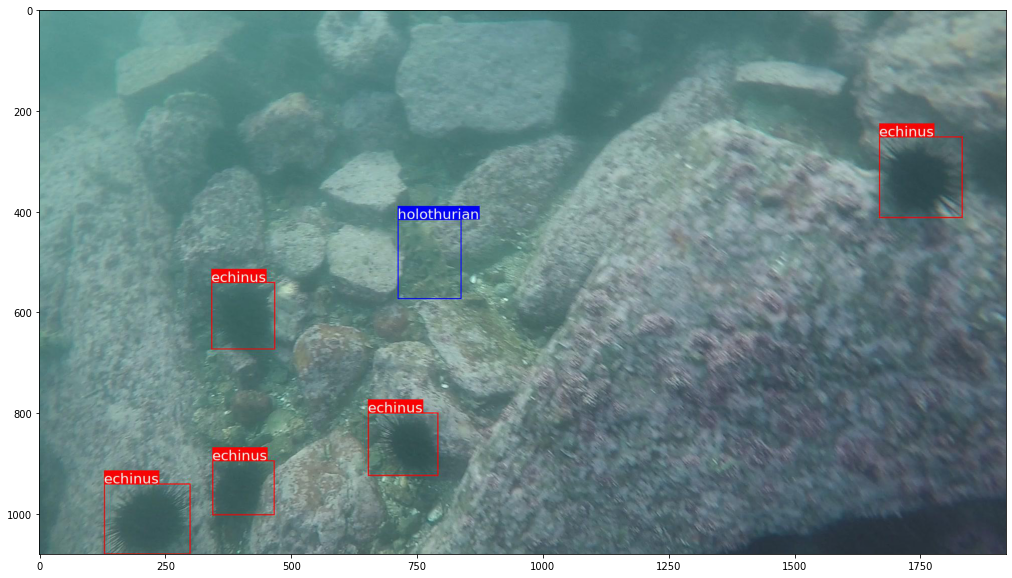

In [8]:
boxed_img = Image.open(osp.join(box_img_dir, '000001.jpg'))
plt.style.use({'figure.figsize': (20, 10)})
plt.imshow(np.array(boxed_img))
plt.show()